In [2]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [3]:
#Set train and test paths
TRAIN_PATH = "/Users/sangeethags/Desktop/SEM8/AI/Assignment1/assignment2/dataset/others/"
GT_PATH = "/Users/sangeethags/Desktop/SEM8/AI/Assignment1/assignment2/dataset/gt/"
TEST_PATH = "/Users/sangeethags/Desktop/SEM8/AI/Assignment1/assignment2/dataset/melanoma/"

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[2]
test_ids = next(os.walk(TEST_PATH))[2]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images ... ')
sys.stdout.flush()
for n, img_file in tqdm(enumerate(train_ids), total=len(train_ids)):
    img = imread(TRAIN_PATH + img_file)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask_file = GT_PATH + img_file[0:12] + "_segmentation.png"    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_train[n] = mask

print('Done!')

Getting and resizing train images ... 


100%|██████████| 1626/1626 [14:10<00:00,  1.91it/s]

Done!


/Users/sangeethags/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


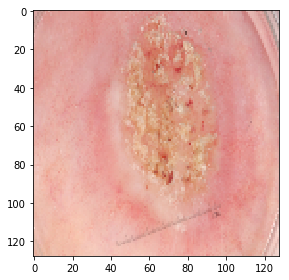

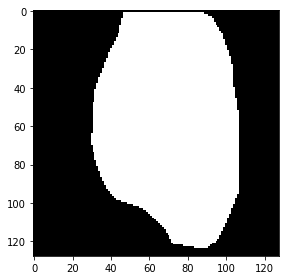

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [7]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=[dice_coef,'accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [8]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=10, 
                    callbacks=[earlystopper, checkpointer])

Train on 1463 samples, validate on 163 samples
Epoch 1/10
1463/1463 [==============================] - 352s 241ms/step - loss: -0.5510 - dice_coef: 0.5510 - acc: 0.7311 - val_loss: -0.6613 - val_dice_coef: 0.6613 - val_acc: 0.8615

Epoch 00001: val_loss improved from inf to -0.66126, saving model to model-dsbowl2018-1.h5
Epoch 2/10
1463/1463 [==============================] - 277s 190ms/step - loss: -0.7444 - dice_coef: 0.7444 - acc: 0.9112 - val_loss: -0.7304 - val_dice_coef: 0.7304 - val_acc: 0.9053

Epoch 00002: val_loss improved from -0.66126 to -0.73043, saving model to model-dsbowl2018-1.h5
Epoch 3/10
1463/1463 [==============================] - 267s 182ms/step - loss: -0.8039 - dice_coef: 0.8039 - acc: 0.9335 - val_loss: -0.7779 - val_dice_coef: 0.7779 - val_acc: 0.9310

Epoch 00003: val_loss improved from -0.73043 to -0.77787, saving model to model-dsbowl2018-1.h5
Epoch 4/10
1463/1463 [==============================] - 264s 181ms/step - loss: -0.8264 - dice_coef: 0.8264 - acc: 

In [11]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, img_file in tqdm(enumerate(test_ids), total=len(test_ids)):
    img = imread(TEST_PATH + img_file)[:,:,:IMG_CHANNELS]
    #sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
    mask_file = GT_PATH + img_file[0:12] + "_segmentation.png"    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    mask_ = imread(mask_file)
    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                  preserve_range=True), axis=-1)
    mask = np.maximum(mask, mask_)
    Y_test[n] = mask

print('Done!')

Getting and resizing test images ... 


100%|██████████| 374/374 [02:03<00:00,  3.02it/s]

Done!


In [12]:
score = model.evaluate(X_test,Y_test)

374/374 [==============================] - 10s 26ms/step


In [14]:
print(score[1]*100)

85.93235784035953


In [ ]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
#preds_test_upsampled = []
#for i in range(len(preds_test)):
#   preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

In [22]:
prediction = model.predict(X_test,verbose="True") 
image = prediction[0]
image[image > 0.5] = 1.
image[image <= 0.5] = 0

/Users/sangeethags/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


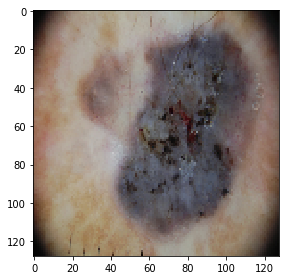

In [25]:
#ix = random.randint(0, len(train_ids))
imshow(X_test[0])
plt.show()

/Users/sangeethags/anaconda2/lib/python2.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


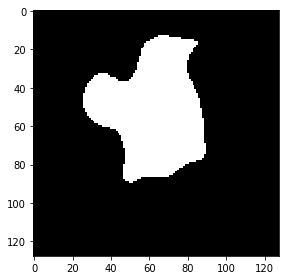

In [24]:
imshow(np.squeeze(image))
plt.show()